# Churn Prediction with Machine Learning
## Thiago Pádua de Carvalho - 2020007066

### Introdução - O que é Churn?
Churn é o termo que define a taxa de evasão de clientes de um serviço ou produto fornecido por uma empresa. Ele é um elemento fundamental para medir a fidelidade e a satisfação dos consumidores, um indicador importante para a saúde financeira de uma companhia, análise de situação no mercado e consequente tomada de decisões estratégicas.

Entender o comportamento dos compradores e prever sua evasão é um desafio para as empresas, pois esse fenômeno está diretamente relacionado com a perda de receita e viabilidade do negócio. Sendo assim é fundamental ter informações sobre o que leva um cliente a cancelar um serviço para identificar pontos de falha, tal como investir assertivamente em ações de retenção.

Com isso em mente, o objetivo deste trabalho é construir um modelo de Machine Learning para prever o churn, tal como identificar aqueles atributos que mais contribuem para a evasão de clientes, permitindo uma visão ampla e detalhada sobre o problema para a posterior tomada de decisões.

### Importação das bibliotecas

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Conhecendo os dados
O dataset utilizado neste trabalho é composto por dois arquivos CSV: um para treinamento e outro para teste.

O arquivo de treinamento para o conjunto de dados de churn contém uma coleção de 440.882 registros de clientes, juntamente com suas respectivas características e rótulos binários. Cada linha no arquivo de treinamento representa um cliente e inclui as seguintes características: idade, gênero, tempo de serviço, frequência de uso, chamadas de suporte, atraso no pagamento, tipo de assinatura, duração do contrato, gasto total e última interação.

O arquivo de teste para o conjunto de dados de churn consiste em 64.374 registros de clientes e serve como um conjunto de dados separado para avaliar o desempenho e a capacidade de generalização dos modelos de previsão de rotatividade treinados. Cada linha no arquivo de teste corresponde a um cliente e contém o mesmo conjunto de características que o arquivo de treinamento. No entanto, os rótulos de churn não estão incluídos no arquivo de teste, pois são usados para avaliar a precisão e a eficácia dos modelos. O arquivo de teste permite avaliar o poder preditivo dos modelos treinados em dados não vistos e obter insights sobre o quão bem eles se generalizam para novos clientes.

Fonte dos dados: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?resource=download&select=customer_churn_dataset-testing-master.csv

### Feature Columns
Atributos numéricos:
- **Age**: Idade
- **Tenure**: Duração em Meses que o cliente consome o serviço
- **Usage Frequency**: número de vezes que o cliente usou o serviço no mês anterior
- **Support Calls**: número de chamadas de suporte feitas pelo cliente no mês anterior
- **Payment Delay**: número de dias de atraso no pagamento do cliente para o mês anteriror
- **Total Spend**: gasto total do cliente com o serviço
- **Last Interaction**: número de dias desde a última interação do cliente com o serviço

Atributos categóricos
- **Gender**: Sexo do cliente (M/F)
- **Subscription Type**: Tipo de assinatura do cliente (Standard, Basic, Premium)
- **Contract Length**: Tipo de duração do contrato do cliente (Annual, Monthly, Quarterly)



### Carregamento dos dados

In [11]:
trainingData = pd.read_csv('data/customer_churn_dataset-training-master.csv')
trainingData.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [12]:
testData = pd.read_csv('data/customer_churn_dataset-testing-master.csv')
testData.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


### Pré-processamento

In [13]:
trainingData = trainingData.dropna()
trainingData.drop(['CustomerID'], axis=1, inplace=True)
X_train, y_train = trainingData.drop('Churn', axis=1), trainingData['Churn']

In [14]:
testData = testData.dropna()
testData.drop(['CustomerID'], axis=1, inplace=True)
X_test, y_test = testData.drop('Churn', axis=1), testData['Churn']

In [15]:
trainingData.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


### Análise Exploratória

In [16]:
numericFeatures = trainingData.select_dtypes(include=['int64', 'float64']).columns
numericFeatures = numericFeatures.drop('Churn')

categoricalFeatures = trainingData.select_dtypes(include=['object']).columns
categoricalFeatures

Index(['Gender', 'Subscription Type', 'Contract Length'], dtype='object')

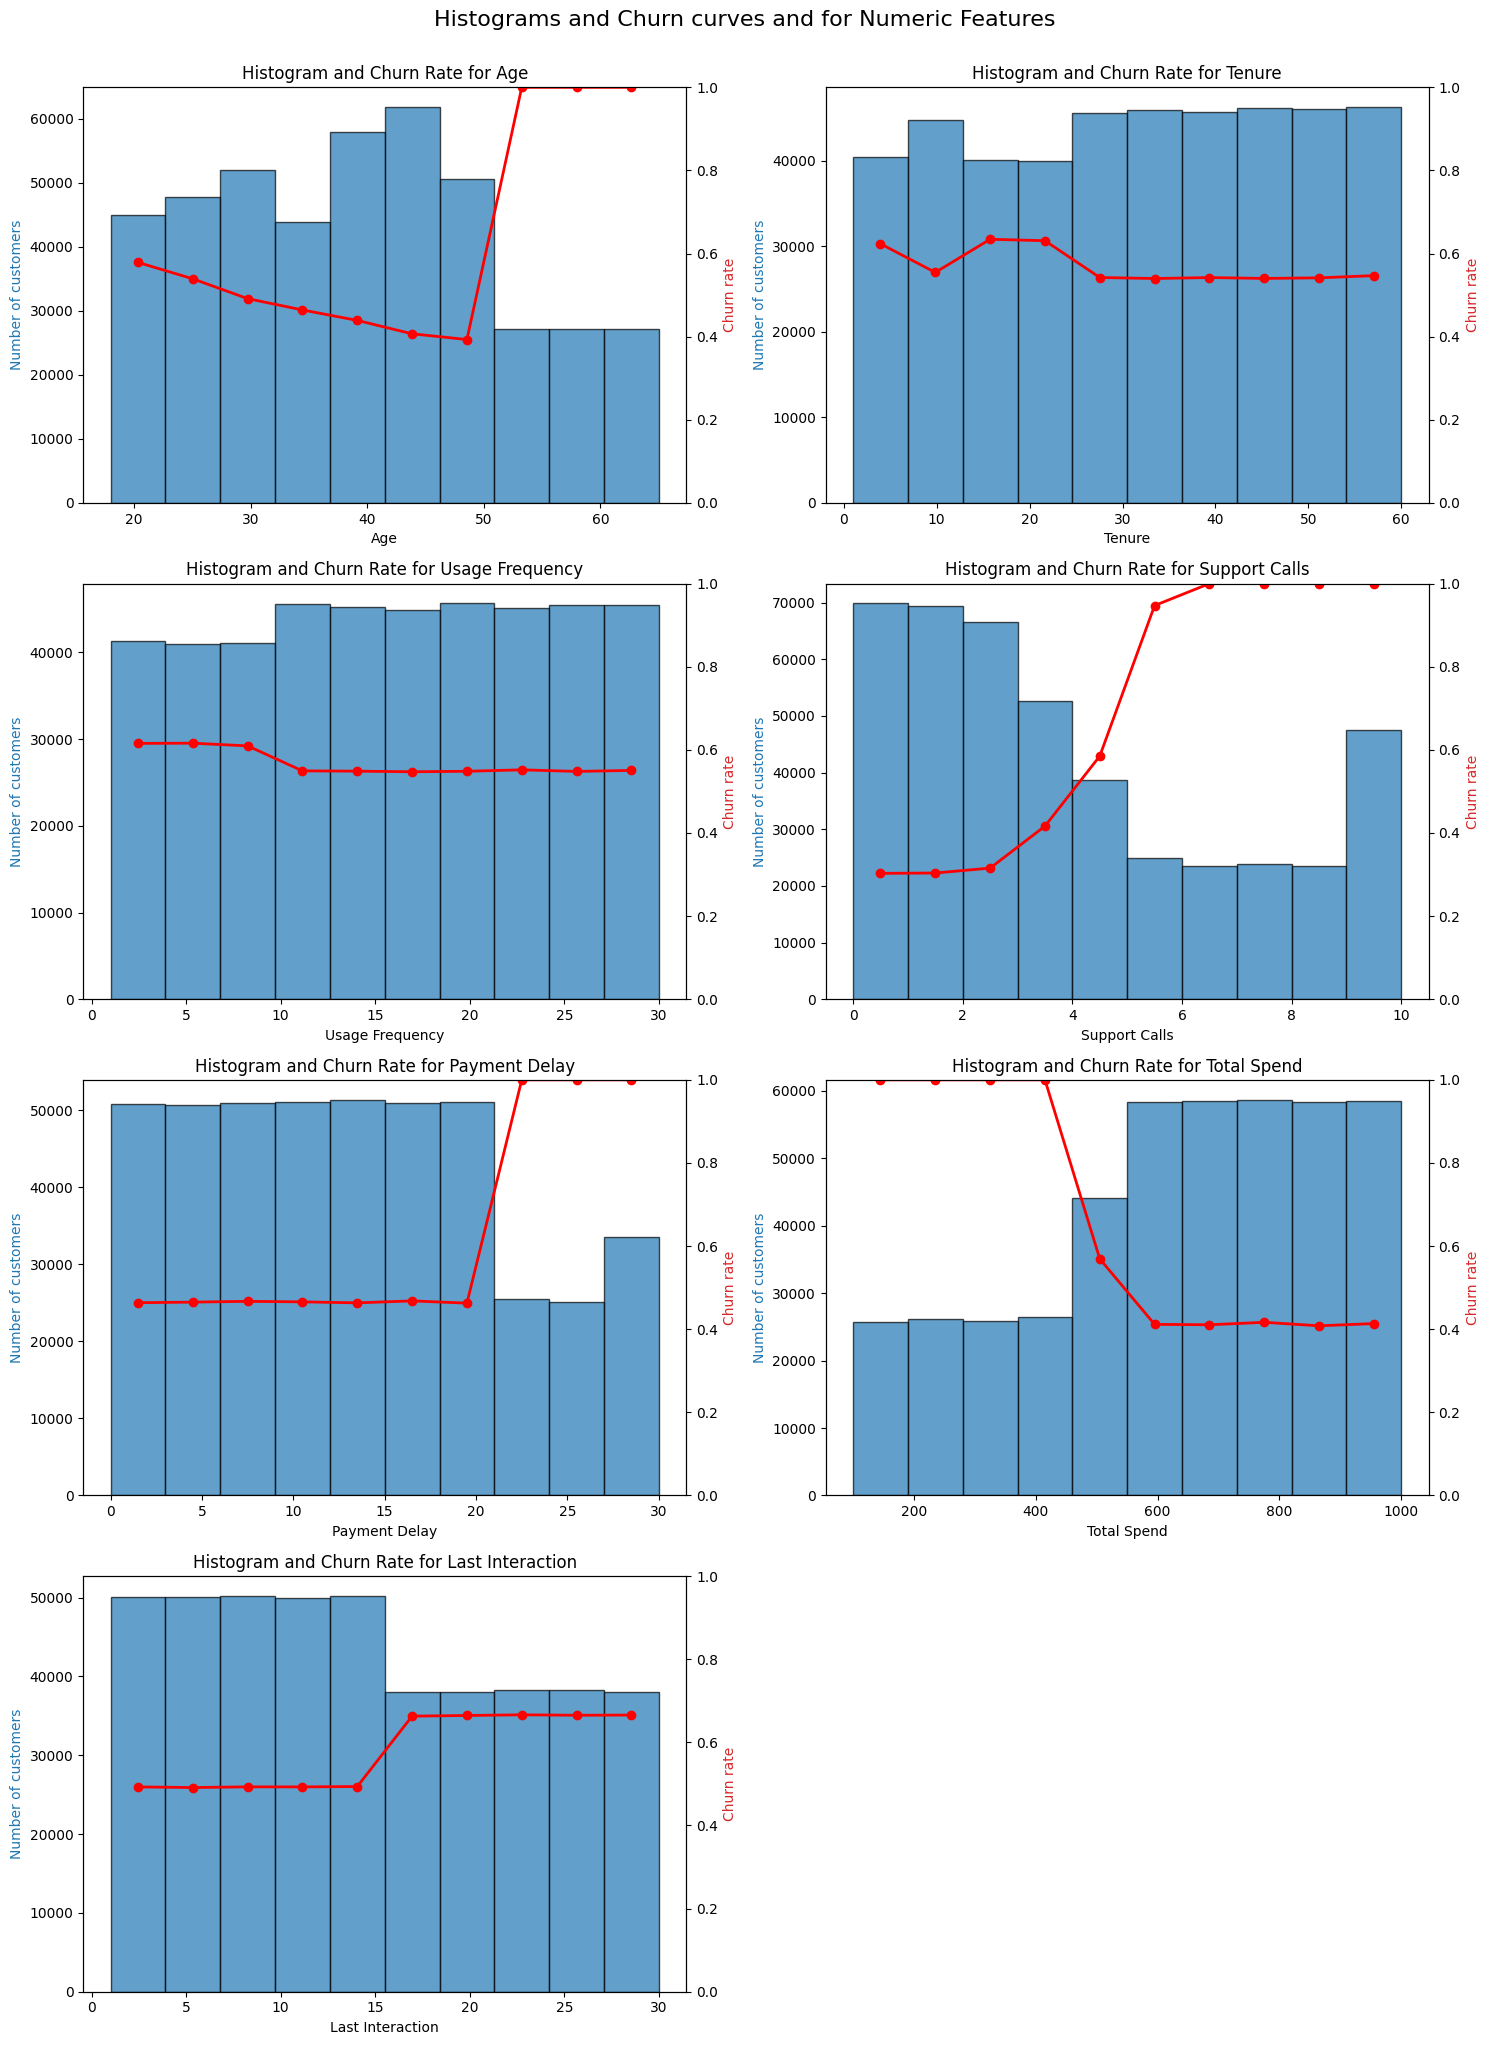

In [45]:
num_cols = 2
num_rows = int(np.ceil(len(numericFeatures) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numericFeatures):
    ax1 = axes[i]

    n, bins, patches = ax1.hist(X_train[column], edgecolor='black', alpha=0.7)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Number of customers', color='tab:blue')

    # Calculate mean churn rate for each bin
    churn_rates = []
    for i in range(len(bins)-1):
        bin_mask = (X_train[column] >= bins[i]) & (X_train[column] < bins[i+1])
        churn_rates.append(y_train[bin_mask].mean())

    # Create a second y-axis to plot the churn rate
    ax2 = ax1.twinx()
    ax2.plot(bins[:-1] + np.diff(bins)/2, churn_rates, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Churn rate', color='tab:red')
    ax2.set_ylim(0, 1)

    ax1.set_title(f'Histogram and Churn Rate for {column}')

# Remove unused axes
for i in range(len(numericFeatures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms and Churn curves and for Numeric Features', fontsize=16, y=1.02)

plt.show()

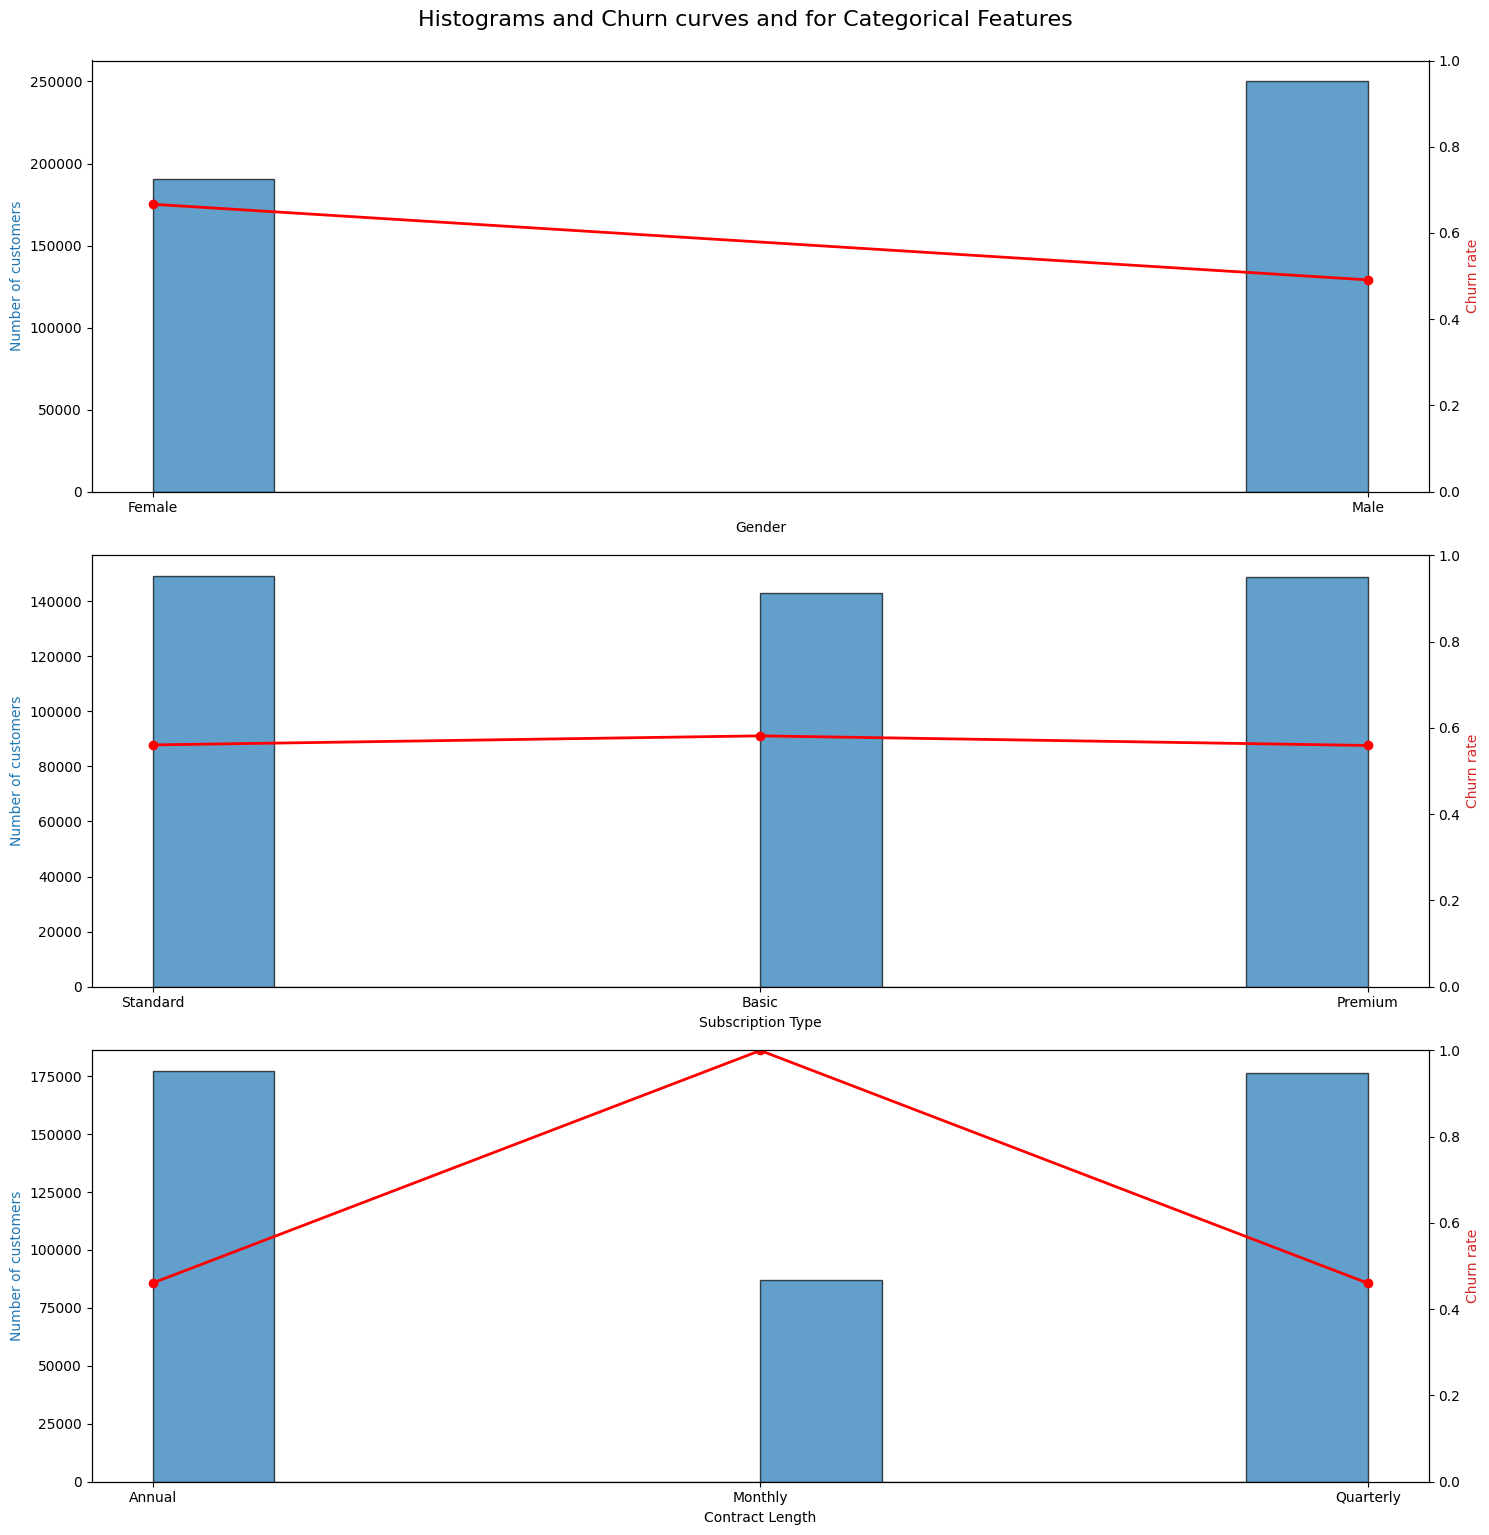

In [46]:
fig, axes = plt.subplots(len(categoricalFeatures), 1, figsize=(15, 5 * len(categoricalFeatures)))

for i, column in enumerate(categoricalFeatures):
    ax1 = axes[i]

    n, bins, patches = ax1.hist(X_train[column], edgecolor='black', alpha=0.7)
    ax1.set_xlabel(column)
    ax1.set_ylabel('Number of customers', color='tab:blue')

    # Calculate mean churn rate for each bin
    churn_rates = []
    for category in X_train[column].unique():
        churn_rates.append(y_train[X_train[column] == category].mean())

    # Create a second y-axis to plot the churn rate
    ax2 = ax1.twinx()
    ax2.plot(X_train[column].unique(), churn_rates, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Churn rate', color='tab:red')

    ax2.set_ylim(0, 1)

# Remove unused axes
for i in range(len(categoricalFeatures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms and Churn curves and for Categorical Features', fontsize=16, y=1.02)

plt.show()